# Importing Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loading the datasets

In [ ]:
transforms = transforms.Compose([transforms.ToTensor() # Conveert image to tensor
                                 , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize image

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms) # Download training data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms) # Download testing data

Files already downloaded and verified
Files already downloaded and verified


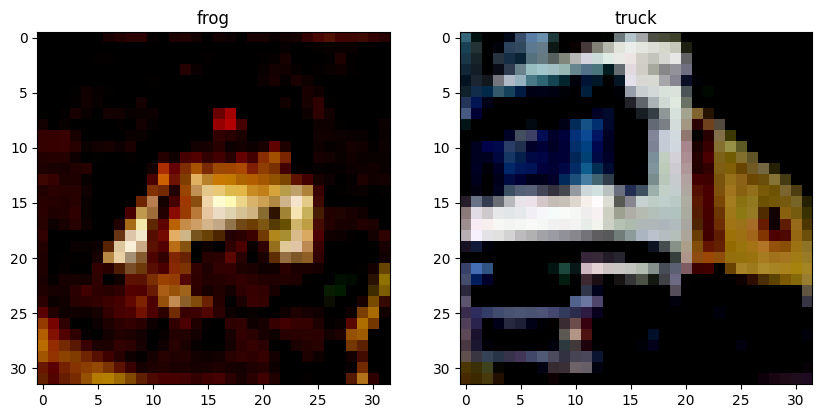

In [ ]:
# Plotting the first 2 images and their labels in the training set
get_label_name = {v: k for k, v in trainset.class_to_idx.items()} # Get the label name from the index
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(trainset[0][0].permute(1, 2, 0))
ax[0].set_title(get_label_name[trainset[0][1]])
ax[1].imshow(trainset[1][0].permute(1, 2, 0))
ax[1].set_title(get_label_name[trainset[1][1]])
plt.show()

# Device Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Defining Hyperparameters

In [ ]:
#Hyperparameters
EPOCH = 10
BATCH_SIZE = 64
learning_rate = 0.001

# Load the data using DataLoader

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # Create training data loader
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) # Create testing data loader

# CNN Architecture

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # 3*32*32 -> 16*32*32
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16*32*32 -> 16*16*16

    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # 16*16*16 -> 32*16*16
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 32*16*16 -> 32*8*8

    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 32*8*8 -> 64*8*8
    self.relu3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 64*8*8 -> 64*4*4

    self.fc1 = nn.Linear(64 * 4 * 4, 256) # 64*4*4 -> 256
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(256, 10) # 256 -> 10

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    x = self.conv3(x)
    x = self.relu3(x)
    x = self.maxpool3(x)

    x = x.view(-1, 64 * 4 * 4)
    x = self.fc1(x)
    x = self.relu4(x)
    x = self.fc2(x)
    return x

# Defining Loss, Optimizer and Initialising the Model

In [ ]:
model = CNN().to(device) # Define model
loss = nn.CrossEntropyLoss() # Define loss function
optimizer = torch.optim.Adam(model.parameters(), learning_rate) # Define optimizer

# Model Training

In [ ]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

def train(model, optimizer, loss_fn, trainloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = loss_fn(outputs, labels)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(correct / total)
    print(f"Training | Loss: {running_loss / len(trainloader)} | Accuracy: {(correct / total) * 100}")

def test(model, loss_fn, testloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_value = loss_fn(outputs, labels)

            running_loss += loss_value.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss.append(running_loss / len(testloader))
    test_accuracy.append(correct / total)
    print(f"Testing | Loss: {running_loss / len(testloader)} | Accuracy: {(correct / total) * 100}")

# Training loop
for epoch in range(EPOCH):
    print(f"EPOCH {epoch + 1}")
    train(model, optimizer, loss, trainloader, device)
    test(model, loss, testloader, device)

EPOCH 1


Training: 100%|██████████| 782/782 [00:16<00:00, 47.14it/s]


Training | Loss: 0.9255683771179765 | Accuracy: 67.44200000000001


Testing: 100%|██████████| 157/157 [00:02<00:00, 54.36it/s]


Testing | Loss: 0.9045961119566753 | Accuracy: 67.71000000000001
EPOCH 2


Training: 100%|██████████| 782/782 [00:17<00:00, 45.74it/s]


Training | Loss: 0.8134915763917177 | Accuracy: 71.452


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.21it/s]


Testing | Loss: 0.8815487198009613 | Accuracy: 69.63000000000001
EPOCH 3


Training: 100%|██████████| 782/782 [00:16<00:00, 48.72it/s]


Training | Loss: 0.7246598460713921 | Accuracy: 74.534


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.60it/s]


Testing | Loss: 0.8188644469163979 | Accuracy: 71.38
EPOCH 4


Training: 100%|██████████| 782/782 [00:17<00:00, 44.83it/s]


Training | Loss: 0.6478387910463012 | Accuracy: 77.386


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.44it/s]


Testing | Loss: 0.7976797629313864 | Accuracy: 72.36
EPOCH 5


Training: 100%|██████████| 782/782 [00:16<00:00, 47.46it/s]


Training | Loss: 0.5800946878502741 | Accuracy: 79.58800000000001


Testing: 100%|██████████| 157/157 [00:03<00:00, 51.15it/s]


Testing | Loss: 0.7963421792741034 | Accuracy: 73.56
EPOCH 6


Training: 100%|██████████| 782/782 [00:17<00:00, 44.91it/s]


Training | Loss: 0.5200236760403799 | Accuracy: 81.634


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.84it/s]


Testing | Loss: 0.8017123305493858 | Accuracy: 72.57000000000001
EPOCH 7


Training: 100%|██████████| 782/782 [00:16<00:00, 48.36it/s]


Training | Loss: 0.46215929614041773 | Accuracy: 83.712


Testing: 100%|██████████| 157/157 [00:03<00:00, 42.47it/s]


Testing | Loss: 0.8495280989416086 | Accuracy: 72.94
EPOCH 8


Training: 100%|██████████| 782/782 [00:16<00:00, 47.84it/s]


Training | Loss: 0.4094763990024776 | Accuracy: 85.654


Testing: 100%|██████████| 157/157 [00:02<00:00, 54.80it/s]


Testing | Loss: 0.8384332698621567 | Accuracy: 73.07000000000001
EPOCH 9


Training: 100%|██████████| 782/782 [00:16<00:00, 48.33it/s]


Training | Loss: 0.35394066796087853 | Accuracy: 87.55199999999999


Testing: 100%|██████████| 157/157 [00:04<00:00, 32.42it/s]


Testing | Loss: 0.9010452789485834 | Accuracy: 73.42999999999999
EPOCH 10


Training: 100%|██████████| 782/782 [00:16<00:00, 48.81it/s]


Training | Loss: 0.31199176634287895 | Accuracy: 88.964


Testing: 100%|██████████| 157/157 [00:02<00:00, 54.56it/s]

Testing | Loss: 0.9755149109728017 | Accuracy: 73.74000000000001


# Plotting Loss and Accuracy

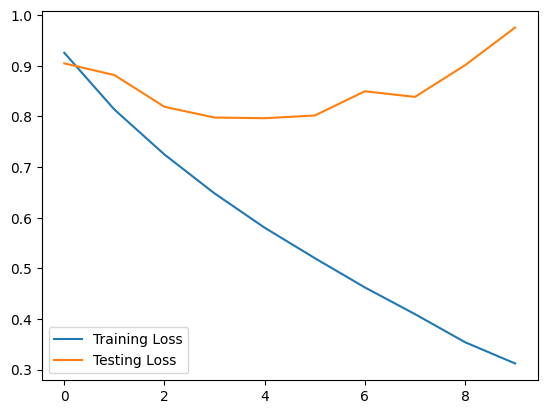

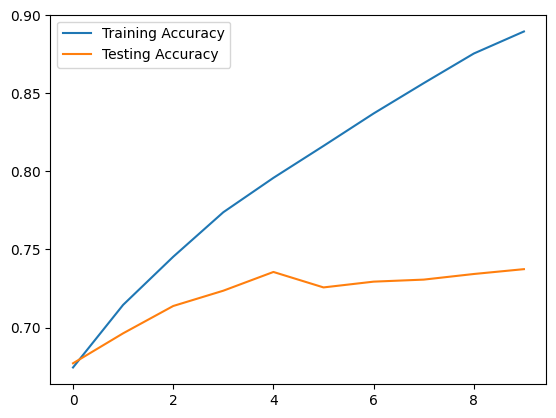

In [ ]:
#Plotting Loss and Accuracy

plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()